In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set(style="whitegrid")
from scipy import stats
import math 


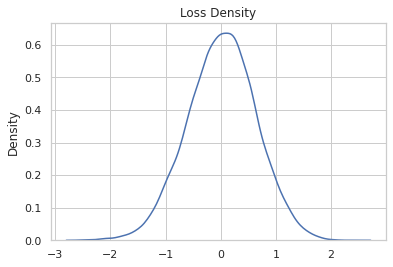

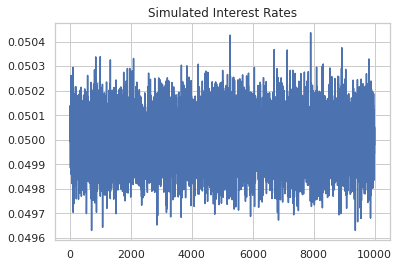

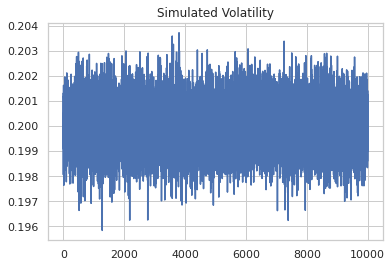

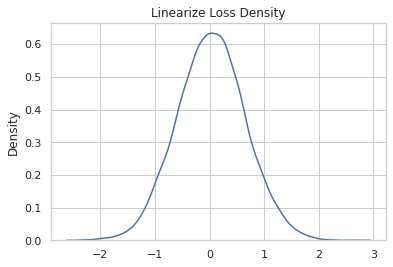

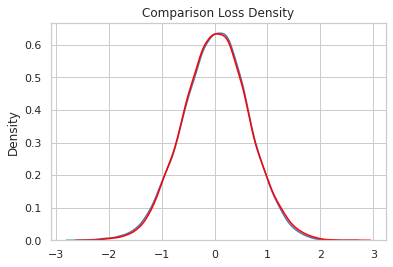

In [ ]:
#EXERCISE 2
pdf, cdf = stats.norm.pdf, stats.norm.cdf

mean = np.zeros(3)
#creating the matrix of covariance 
cov = np.zeros((3,3))
std1, std2, std3 = 0.01, 10**(-4), 10**(-3)
cov[0,0] = std1**2
cov[1,1] = std2**2
cov[2,2] = std3**2
cov[2,0] = -0.5 * std1 * std3
cov[0,2] = cov[2,0]


#simulate X = (X1, X2, X3) 10'000 times 
change_dt = np.random.multivariate_normal(mean, cov, 10000)


s_t = 100
r_t = 0.05
sigma_t = 0.2
t, T = 0, 1
K = 100
dt = 1/252

#empty matrix
values_t_dt = np.empty((10000, 3))              

#calculating the r_t+dt and sigma_t+dt
values_t_dt[:,1:3]  =  change_dt[:,1:3] + np.array([r_t, sigma_t])
#calculating s_t+dt from the log return and s_t
values_t_dt[:,0] = np.exp(change_dt[:,0]) * s_t


#function to calculate black scholes call price, without dividend 
def black_scholes_call(t, T, s, k, r, sigma): 
    d1 = ( np.log(s/k) + (r + 0.5*sigma**2)*(T-t) )/(sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    price = s * cdf(d1) - k*np.exp(-r *(T-t))*cdf(d2)
    return price


#price at t
price_t = black_scholes_call(t, T, s_t, K, r_t, sigma_t)

#price at t+dt
price_t_dt = black_scholes_call(t + dt, T, values_t_dt[:,0], K, values_t_dt[:,1], values_t_dt[:,2])

#the loss is - (p_t_+dt - p_t)
loss = - (price_t_dt - price_t)

#plotting the density 
sns.kdeplot(loss)
plt.title("Loss Density")
plt.show()

#do we have negative interest rates and standard deviations ?
plt.plot(values_t_dt[:,1])
plt.title("Simulated Interest Rates")
plt.show()

plt.plot(values_t_dt[:,2])
plt.title("Simulated Volatility")
plt.show()


#function to calculate greek 
def greeks(s, r, sigma, t, T, k):
    tau = T-t
    d1 = ( np.log(s/k) + (r + 0.5*sigma**2)*(tau) )/(sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    delta = cdf(d1)
    theta = s*(-pdf(d1)*sigma/(2*np.sqrt(tau))) - r * np.exp(-r*tau) * k * cdf(d2)
    vega = s * math.sqrt(tau) * pdf(d1)
    rho = k * tau * np.exp(-r*tau)*cdf(d2)
    return theta, delta, vega, rho 

theta, delta, vega, rho  = greeks(s_t, r_t, sigma_t, t, T, K)

fun_linear_loss = lambda x: - (theta * dt + delta*s_t*x[:,0] + rho*x[:,1] + vega*x[:,2])

loss_linearize = fun_linear_loss(change_dt)
sns.kdeplot(loss_linearize)
plt.title("Linearize Loss Density")
plt.show()


#we can even confront the two 
sns.kdeplot(loss)
sns.kdeplot(loss_linearize, color = "red")
plt.title("Comparison Loss Density")
plt.show()



Standard deviations: [0.00998883 0.01004165 0.01004818 0.0100398 ]


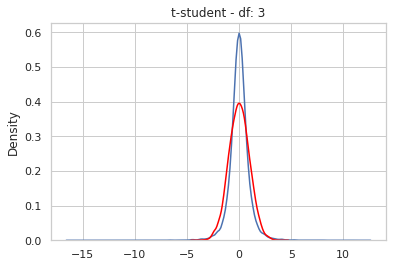

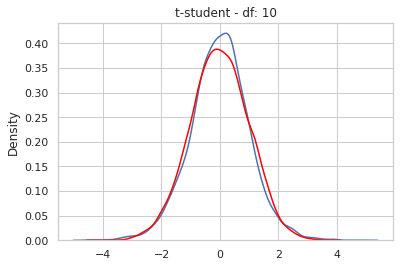

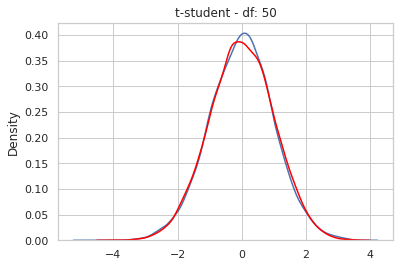

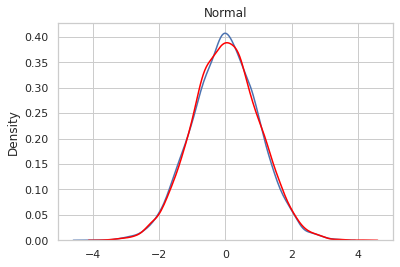

In [ ]:
#EXERCISE 1

d = 1
lambda1 = 1
mean = 0 
std = 0.01
s_t = 100
n = 10000

def scale_factor(df, objective):    
    variance = df/(df-2)
    standard_dev = math.sqrt(variance)
    return (objective/standard_dev)


df = [3 ,10, 50]
simulation = [ scale_factor(j, std)*np.random.standard_t(df = j, size = n) for j in df ] 
simulation.append(np.random.normal(loc = 0, scale = std, size = n))

simulation = np.array(simulation).transpose()

#checking the standard deviation 
print(f"Standard deviations: {simulation.std(axis = 0)}")

def loss(lambda1, s, x):
    return - lambda1 * s * (np.exp(x) - 1 )

losses = loss(lambda1, s_t, simulation)
names = [f"t-student - df: {j}" for j in df]
names.append("Normal")


def density(x, name):
    sns.kdeplot(x)
    sns.kdeplot(np.random.normal(loc = x.mean(), scale = x.std(), size = n), color = "red")
    plt.title(name)
    plt.show()
    
for j in range(len(df) + 1 ):
    density(losses[:,j], names[j])